In [2]:
from keras.metrics import AUC
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd 
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers



from PIL import Image
from PIL import ImageDraw
train_on_gpu = True


In [61]:
DIR = './histopathologic-cancer-detection'

df_labels = pd.read_csv(f'{DIR}/train_labels.csv')
df_samples = pd.read_csv(f'{DIR}/sample_submission.csv')
df_labels.head()

id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

In [6]:
train = f"{DIR}/train/"
test = f"{DIR}/test"

print("Number of training images: {}".format(len(os.listdir(train))))
print("Number of test images: {}".format(len(os.listdir(test))))

Number of training images: 220025
Number of test images: 57458


In [7]:
img_train = os.listdir(train)
img_test = os.listdir(test)

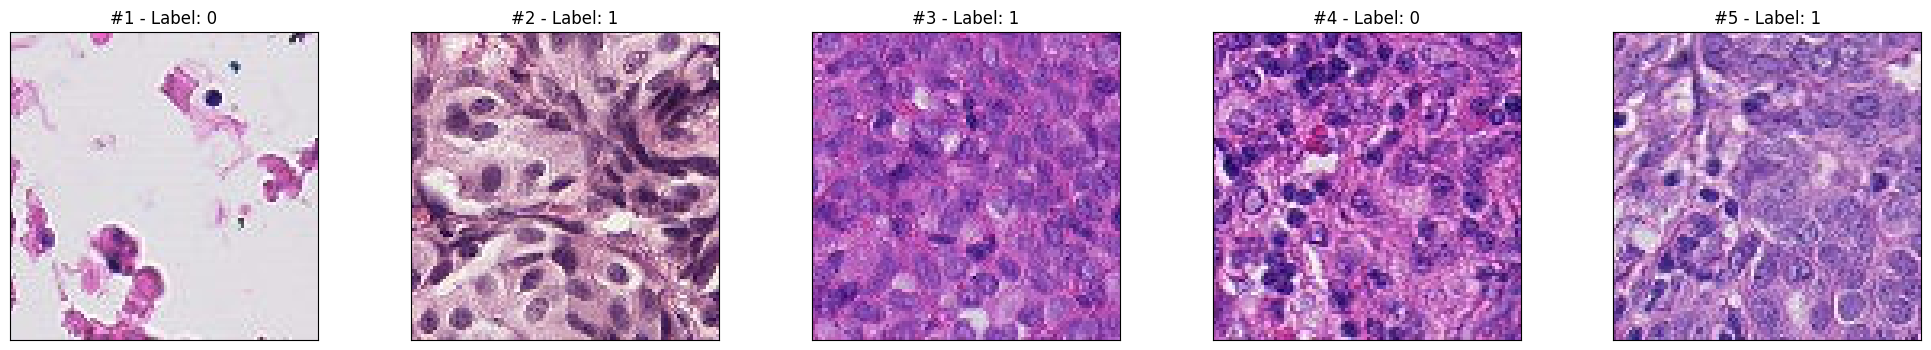

In [8]:
fig = plt.figure(figsize=(25, 4))

for i in range(5):
    ax = fig.add_subplot(1, 5, i + 1, xticks=[], yticks=[])
    im = Image.open(train + img_train[i])
    plt.imshow(im)
    label = df_labels.loc[df_labels['id'] == img_train[i].split('.')[0], 'label'].values[0]
    ax.set_title(f'#{i+1} - Label: {label}')

In [9]:
missing_values = df_labels.isnull().sum()
missing_values

id       0
label    0
dtype: int64

In [38]:
df_labels[df_labels.duplicated(keep=False)]
df_labels['label'].value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

<Axes: >

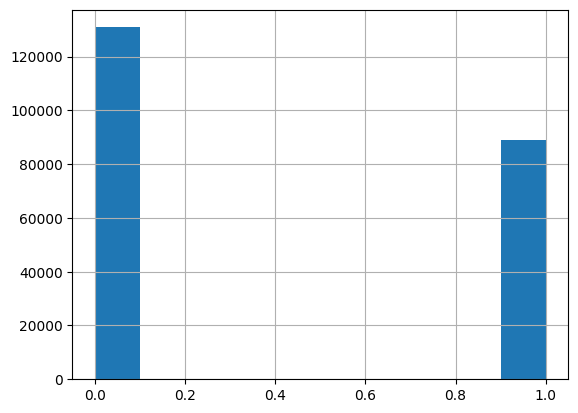

In [12]:
malignant = df_labels.loc[df_labels['label']==1]['id'].values    
normal = df_labels.loc[df_labels['label']==0]['id'].values      
df_labels['label'].hist()

In [13]:
def plot_fig(ids,title,nrows=3,ncols=3):

    fig,ax = plt.subplots(nrows,ncols,figsize=(7,7))
    plt.subplots_adjust(wspace=0, hspace=0) 
    for i,j in enumerate(ids[:nrows*ncols]):
        fname = os.path.join(train ,j +'.tif')
        img = Image.open(fname)
        idcol = ImageDraw.Draw(img)
        idcol.rectangle(((0,0),(95,95)),outline='white')
        plt.subplot(nrows, ncols, i+1) 
        plt.imshow(np.array(img))
        plt.axis('off')

    plt.suptitle(title, y=0.94)

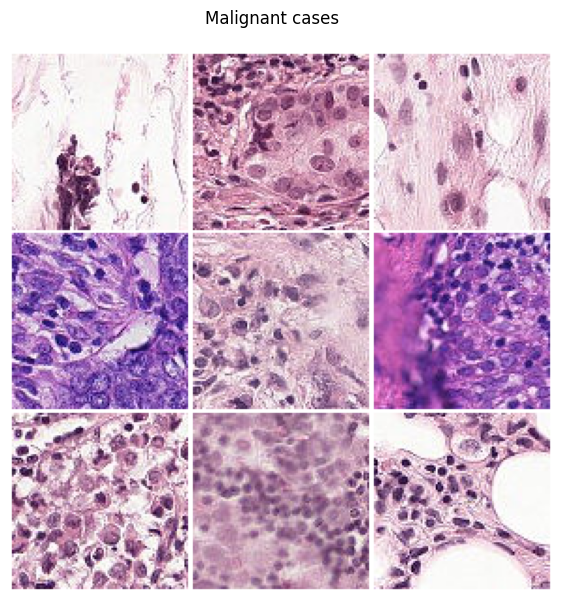

In [14]:
plot_fig(malignant,'Malignant cases')

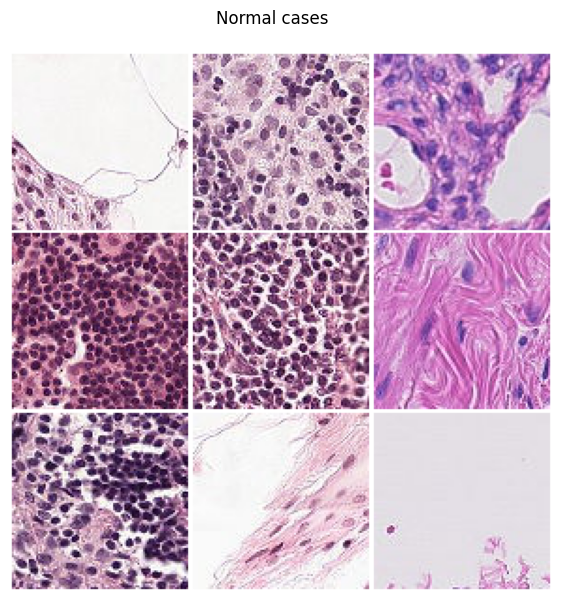

In [15]:
plot_fig(normal,'Normal cases')

In [16]:
train_data, val_data = train_test_split(df_labels, test_size=0.2, random_state=42, stratify=df_labels['label'])

In [17]:
train_data = train_data.astype(str)
val_data = val_data.astype(str)
print(train_data.shape,val_data.shape)

(176020, 2) (44005, 2)


In [18]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [19]:
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [20]:
train_data['id'] += '.tif'
val_data['id'] += '.tif'

In [21]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory = train,
    x_col = 'id',
    y_col = 'label',
    target_size=(96,96),
    batch_size=32,
    class_mode='binary'
)

Found 176020 validated image filenames belonging to 2 classes.


In [22]:
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory = train,
    x_col='id',
    y_col='label',
    target_size=(96,96),
    batch_size=32,
    class_mode='binary'
)

Found 44005 validated image filenames belonging to 2 classes.


In [23]:
# 
test_data = df_samples.astype(str)
test_data['id'] += '.tif'

In [24]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory = test,
    x_col='id',
    y_col='label',
    target_size=(96,96),
    batch_size=32,
)

Found 57458 validated image filenames belonging to 1 classes.


In [45]:
# Define the CNN function
def CNN(model):
    model.add(layers.Conv2D(16, (3,3), activation='relu', input_shape=(96,96,3)))
    model.add(layers.Conv2D(16, (3,3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(3,3)))

    # Batch normalization
    model.add(layers.Conv2D(32, (3,3), activation='relu'))
    model.add(layers.Conv2D(32, (3,3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(3,3)))

    # Batch normalization
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(3,3)))

    # Convert to 1D vector
    model.add(layers.Flatten())

    # Increase number of units
    # model.add(layers.Dense(128, activation='relu'))
    # model.add(layers.Dropout(0.5))

    # Classification layers
    # Use a sigmoid for binary classification
    # Adding an extra dense layer
    model.add(layers.Dense(64, activation='sigmoid'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [46]:
RMS_model = CNN(tf.keras.Sequential())

RMS_model.compile(
    optimizer = 'RMSprop',
    loss = 'binary_crossentropy',
    metrics = [AUC()]
)

RMS_history = RMS_model.fit(
    train_generator,
    validation_data = val_generator,
    epochs = 6
)


prediction_labels_1 = RMS_model.predict(test_generator)


Epoch 1/6
5501/5501 [==============================] - 324s 59ms/step - loss: 0.4047 - auc_4: 0.8914 - val_loss: 1.1372 - val_auc_4: 0.8175
Epoch 2/6
5501/5501 [==============================] - 315s 57ms/step - loss: 0.3487 - auc_4: 0.9204 - val_loss: 0.3545 - val_auc_4: 0.9256
Epoch 3/6
5501/5501 [==============================] - 297s 54ms/step - loss: 0.3280 - auc_4: 0.9297 - val_loss: 0.4501 - val_auc_4: 0.9230
Epoch 4/6
5501/5501 [==============================] - 921s 168ms/step - loss: 0.3140 - auc_4: 0.9357 - val_loss: 0.5892 - val_auc_4: 0.8874
Epoch 5/6
5501/5501 [==============================] - 305s 55ms/step - loss: 0.2978 - auc_4: 0.9420 - val_loss: 0.5642 - val_auc_4: 0.8892
Epoch 6/6
1796/1796 [==============================] - 969s 540ms/step


In [47]:
model_pred_df_1 = pd.DataFrame(columns=['id', 'label'])
img_test=sorted(img_test)


model_pred_df_1['id'] = [filename.split('.')[0] for filename in img_test]
model_pred_df_1['label'] = np.round(prediction_labels_1.flatten()).astype('int')
model_pred_df_1

id  label
0      00006537328c33e284c973d7b39d340809f7271b      0
1      0000ec92553fda4ce39889f9226ace43cae3364e      0
2      00024a6dee61f12f7856b0fc6be20bc7a48ba3d2      1
3      000253dfaa0be9d0d100283b22284ab2f6b643f6      0
4      000270442cc15af719583a8172c87cd2bd9c7746      0
...                                         ...    ...
57453  fffdd1cbb1ac0800f65309f344dd15e9331e1c53      1
57454  fffdf4b82ba01f9cae88b9fa45be103344d9f6e3      0
57455  fffec7da56b54258038b0d382b3d55010eceb9d7      0
57456  ffff276d06a9e3fffc456f2a5a7a3fd1a2d322c6      0
57457  ffffeb4c0756098c7f589b7beec08ef1899093b5      0

[57458 rows x 2 columns]

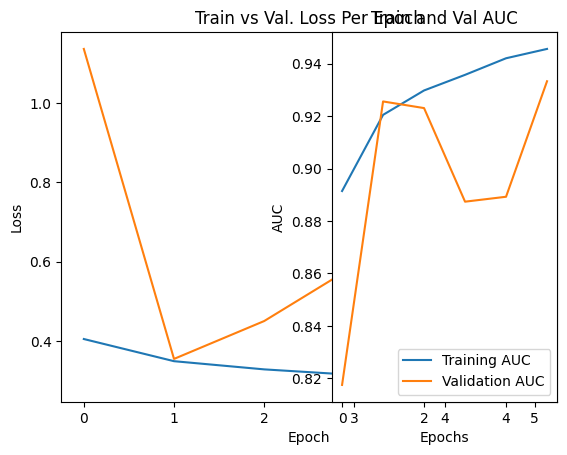

In [50]:
plt.plot(RMS_history.history['loss'], label='loss')
plt.plot(RMS_history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train vs Val. Loss Per Epoch')

plt.subplot(1, 2, 2)
# print(RMS_history.history)
plt.plot(RMS_history.history['auc_4'], label='Training AUC')
plt.plot(RMS_history.history['val_auc_4'], label='Validation AUC')
plt.title('Train and Val AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

plt.show()

In [51]:
SGD_model = CNN(tf.keras.Sequential())
SGD_model.compile(
    optimizer = 'SGD',
    loss = 'binary_crossentropy',
    metrics = [AUC()]
)

SGD_history= SGD_model.fit(
    train_generator,
    validation_data = val_generator,
    epochs = 6
)


prediction_labels_2 = SGD_model.predict(test_generator)

Epoch 1/6
5501/5501 [==============================] - 313s 57ms/step - loss: 0.4478 - auc_5: 0.8643 - val_loss: 0.4554 - val_auc_5: 0.8968
Epoch 2/6
5501/5501 [==============================] - 320s 58ms/step - loss: 0.3825 - auc_5: 0.9037 - val_loss: 0.4989 - val_auc_5: 0.8620
Epoch 3/6
5501/5501 [==============================] - 315s 57ms/step - loss: 0.3602 - auc_5: 0.9150 - val_loss: 0.4121 - val_auc_5: 0.9096
Epoch 4/6
5501/5501 [==============================] - 293s 53ms/step - loss: 0.3432 - auc_5: 0.9228 - val_loss: 0.8620 - val_auc_5: 0.8804
Epoch 5/6
5501/5501 [==============================] - 298s 54ms/step - loss: 0.3274 - auc_5: 0.9298 - val_loss: 0.4043 - val_auc_5: 0.9014
Epoch 6/6
1796/1796 [==============================] - 25s 14ms/step


In [52]:
model_pred_df_2 = pd.DataFrame(columns=['id', 'label'])
img_test=sorted(img_test)


model_pred_df_2['id'] = [filename.split('.')[0] for filename in img_test]
model_pred_df_2['label'] = np.round(prediction_labels_2.flatten()).astype('int')
model_pred_df_2

id  label
0      00006537328c33e284c973d7b39d340809f7271b      0
1      0000ec92553fda4ce39889f9226ace43cae3364e      0
2      00024a6dee61f12f7856b0fc6be20bc7a48ba3d2      0
3      000253dfaa0be9d0d100283b22284ab2f6b643f6      1
4      000270442cc15af719583a8172c87cd2bd9c7746      0
...                                         ...    ...
57453  fffdd1cbb1ac0800f65309f344dd15e9331e1c53      0
57454  fffdf4b82ba01f9cae88b9fa45be103344d9f6e3      0
57455  fffec7da56b54258038b0d382b3d55010eceb9d7      0
57456  ffff276d06a9e3fffc456f2a5a7a3fd1a2d322c6      0
57457  ffffeb4c0756098c7f589b7beec08ef1899093b5      0

[57458 rows x 2 columns]

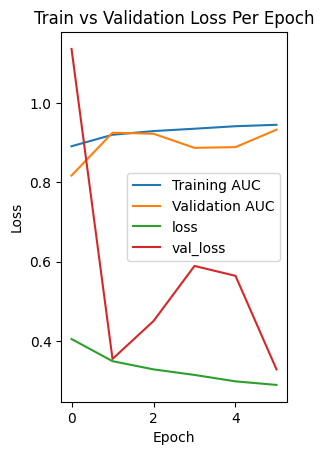

In [55]:
plt.subplot(1, 2, 2)
plt.plot(RMS_history.history['auc_4'], label='Training AUC')
plt.plot(RMS_history.history['val_auc_4'], label='Validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

plt.plot(RMS_history.history['loss'], label='loss')
plt.plot(RMS_history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train vs Validation Loss Per Epoch')

plt.show()

In [56]:
RMS_csv = model_pred_df_1.to_csv('RMS_model_predictions.csv', index=False)
SGD_csv = model_pred_df_2.to_csv('SGD_model_predictions.csv', index=False)

In [57]:
RMS_csv

In [58]:
SGD_csv

In [59]:
# Save model.
SGD_model.save("cancer_model.h5")

/Users/jedhelmers/Documents/Development/coursera/CNN/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
